I will be using the concept of transfer learning (or pre training) which is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet as a feature extractor.
The process will go as - take a pretrained ConvNet, remove the last fully-connected layer. After removing the last layer, what we have is just another neural network i.e. a stack of space tranformations. And the output of this stack can be pumped into a single layer which can classify the image into various categories.


Movie posters as images will be pumped through the pre-trained network to extract the visual features from the posters. Then, using these features as descriptors for the image, and genres as the labels, we train a simpler neural network from scratch which learns to do simply classification on this dataset. These 2 steps are exactly what we are going to do for predicting genres from movie posters.

We use a pre-trained deep neural network made available from the Visual Geometry Group at Oxford University, one of the most popular methods called the VGG-net. Or as they call it, we will extract the VGG features of an image. Keras which uses tensor flow as backend is a library that makes it very easy for us to operate on VGG.

So, here is the process of Forward Propogating the image through VGG and chopping off the last layer using Keras

In [1]:
import pickle
import os
# Loading the list of movies we had downloaded posters for eariler - 
f=open('poster_movies.pckl','r')
posterMovies=pickle.load(f)
f.close()
del f

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import pickle
model = VGG16(weights='imagenet', include_top=False)

In [5]:
posterFolder='posters_final/'

In [6]:
allnames=os.listdir(posterFolder)
imnames=[j for j in allnames if j.endswith('.jpg')]
featureList=[]
genreList=[]
fileOrder=[]
finalMoviesSet=[]
print "Started extracting VGG features for scraped images."
print "Total images = ",len(imnames)
failedFiles=[]
succesfulFiles=[]
i=0
for mov in posterMovies:
    i+=1
    movName=mov['original_title']
    movName1=movName.replace(':','/')
    posterName=movName.replace(' ','_')+'.jpg'
    if posterName in imnames:
        imgPath=posterFolder+posterName
        imname=posterName
        try:
            img = image.load_img(imgPath, target_size=(224, 224))
            succesfulFiles.append(imname)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            features = model.predict(x)
            fileOrder.append(imgPath)
            featureList.append(features)
            genreList.append(mov['genre_ids'])
            finalMoviesSet.append(mov)
            if np.max(np.asarray(featureList))==0.0:
                print('problematic',i)
            if i>1:
                print "Working on Image : ",i
        except:
            failedFiles.append(imname)
            continue
        
    else:
        continue
print "VGG features extracted"

Started extracting VGG features for scraped images.
Total images =  1292
VGG features extracted


In [15]:
#f=open('final_movies_set.pckl','wb')
#pickle.dump(finalMoviesSet,f)
#f.close()
#del f

print len(featureList)
print len(genreList)

1278
1278


In [16]:
#listPickled=(featureList,fileOrder,failedFiles,succesfulFiles,genreList)
#f=open('posters_new_features.pckl','wb')
#pickle.dump(list_pickled,f)
#f.close()
#del f
print("Features dumped to pickle file")

Features dumped to pickle file


In [17]:
f7=open('posters_new_features.pckl','rb')
listPickled=pickle.load(f7)
f7.close()
print "Features loaded back succesfully"

Features loaded back succesfully


Training a neural network using these VGG features

In [21]:
(a,b,c,d)=featureList[0].shape
featureSize=a*b*c*d
print featureSize

25088


The final movie poster set for which we have all the information we need, is 1278 movies. Now, we are gonna make an X numpy array containing the visual features of one image per row. So, the VGG features are reshaped to be in the shape (1,25088) and we finally obtain a matrix of shape (1265,25088)

In [22]:
npFeatures=np.zeros((len(featureList),featureSize))
for i in range(len(featureList)):
    feat=featureList[i]
    reshapedFeat=feat.reshape(1,-1)
    npFeatures[i]=reshapedFeat

In [24]:
X=npFeatures

Our binarized Y numpy array contains the binarized labels corresponding to the genre IDs of the 1278 movies

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb=MultiLabelBinarizer()
Y=mlb.fit_transform(genreList)
Y.shape

(1278, 20)

In [26]:
visualProblemData=(X,Y)
#Commented these two sections to avoid using them again while debugging
#f=open('visual_problem_data_clean.pckl','wb')
#pickle.dump(visualProblemData,f)
#f.close()
#del f

In [27]:
#Commented these two sections to avoid using them again while debugging
#f8=open('visual_problem_data_clean.pckl','rb')
#visualFeatures=pickle.load(f8)
#f8.close()

In [28]:
(X,Y)=visualFeatures

In [29]:
X.shape

(1278, 25088)

In [30]:
#Again, dividing data into test set and train set
mask = np.random.rand(len(X)) < 0.8
XTrain=X[mask]
XTest=X[~mask]
YTrain=Y[mask]
YTest=Y[~mask]
XTest.shape

(270, 25088)

Now is the step to create our own keras neural network which would use the VGG features and then classify movie genres.

Sequential() allows us to make models which follow this sequential order of layers. Different kinds of layers like Dense, Conv2D etc can be used, and many activation functions like RELU, Linear etc are also available as per it's documentation.

The model used has just 1 hidden layer between the VGG features and the final output layer (Since all these Computations are performed on a pc of 4GB RAM).

An image goes into this network with the dimensions (1,25088), the first layer's output is 1024 dimensional. This hidden layer output undergoes a pointwise RELU activation. This output gets transformed into the output layer of 20 dimensions. It goes through a sigmoid.
The sigmoid, or the squashing function, squashes numbers between 0 and 1, and thus, by squashing the score of each of the 20 output labels between 0 and 1, sigmoid lets us interpret their scores as probabilities. 

Then, finally, we just pick the classes top 3 or 5 probability scores as the predicted genres for the movie poster.

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
modelVisual = Sequential([
    Dense(1024, input_shape=(25088,)),
    Activation('relu'),
    Dense(256),
    Activation('relu'),
    Dense(20),
    Activation('sigmoid'),
])
opt = optimizers.rmsprop(lr=0.0001, decay=1e-6)

#sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.4, nesterov=False)
modelVisual.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

We train the model using the fit() function. 
Parameters of fit():
1. Training features
2. Training labels
3. Epochs
4. Batch_size 
5. Verbose.

Data loading is done in batches to limit size of data set being loaded into RAM and affecting speed. 

So, the no. of times model is updated = (Total Samples/Batch Size) * (Epochs)

In [33]:
modelVisual.fit(XTrain, YTrain, epochs=10, batch_size=64,verbose=1)

Epoch 1/10
1008/1008 [==============================] - 40s - loss: 2.3607 - acc: 0.8053      

In [35]:
modelVisual.fit(XTrain, YTrain, epochs=50, batch_size=64,verbose=0)

In [36]:
YPreds=modelVisual.predict(XTest)

In [37]:
YPreds

array([[  7.27609292e-12,   1.75908992e-11,   1.98430031e-19, ...,
          5.49552124e-23,   1.98271644e-29,   4.75863297e-28],
       [  5.93728013e-03,   4.77277189e-15,   9.96230423e-01, ...,
          1.85911435e-26,   1.29068620e-35,   8.64650040e-29],
       [  2.12460202e-10,   1.15372190e-09,   3.22364065e-26, ...,
          9.17593231e-21,   1.19664792e-21,   7.14417403e-15],
       ..., 
       [  4.29314715e-22,   3.42673698e-13,   1.80973480e-25, ...,
          4.20957463e-07,   1.70661174e-18,   2.19490355e-12],
       [  4.37925592e-23,   4.85806470e-20,   3.18443880e-29, ...,
          2.51321020e-10,   1.56455880e-25,   1.07147053e-01],
       [  1.70027020e-10,   2.32679104e-15,   1.55406396e-20, ...,
          7.71920776e-13,   1.42986812e-11,   1.66034506e-10]], dtype=float32)

In [39]:
sum(sum(YPreds))

493.47814011164388

In [40]:
(sum(YPreds[0]))

1.2284418556224785

In [41]:
(sum(YPreds[1]))

3.0019511075627423

In [42]:
f=open('Genredict.pckl','rb')
GenreIDToName=pickle.load(f)
f.close()
del f

In [44]:
GenreIDToName

{12: u'Adventure',
 14: u'Fantasy',
 16: u'Animation',
 18: u'Drama',
 27: u'Horror',
 28: u'Action',
 35: u'Comedy',
 36: u'History',
 37: u'Western',
 53: u'Thriller',
 80: u'Crime',
 99: u'Documentary',
 878: u'Science Fiction',
 9648: u'Mystery',
 10402: u'Music',
 10749: u'Romance',
 10751: u'Family',
 10752: u'War',
 10769: 'Foreign',
 10770: u'TV Movie'}

In [48]:
sortedGenreIds=sorted(list(GenreIDToName.keys()))

Again, Evaluating the model, using precision recall method

In [49]:
def precision_recall(gt,preds):
    TP=0
    FP=0
    FN=0
    for t in gt:
        if t in preds:
            TP+=1
        else:
            FN+=1
    for p in preds:
        if p not in gt:
            FP+=1
    if TP+FP==0:
        precision=0
    else:
        precision=TP/float(TP+FP)
    if TP+FN==0:
        recall=0
    else:
        recall=TP/float(TP+FN)
    return precision,recall

In [54]:
precs=[]
recs=[]
for i in range(len(YPreds)):
    row=YPreds[i]
    gtGenres=YTest[i]
    gtGenreNames=[]
    for j in range(20):
        if gtGenres[j]==1:
            gtGenreNames.append(GenreIDToName[sortedGenreIds[j]])
    top3=np.argsort(row)[-3:]
    predictedGenres=[]
    for genre in top3:
        predictedGenres.append(GenreIDToName[sortedGenreIds[genre]])
    (precision,recall)=precision_recall(gtGenreNames,predictedGenres)
    precs.append(precision)
    recs.append(recall)
    if i%20==0:
        print "Predicted: ",','.join(predictedGenres)," Actual: ",','.join(gtGenreNames)
        
print "Mean precision = ", np.mean(np.asarray(precs)),"," ,"Mean Recalls = ", np.mean(np.asarray(recs))

Predicted:  Horror,Thriller,Drama  Actual:  Adventure,Drama,Science Fiction
Predicted:  Fantasy,Drama,Comedy  Actual:  Fantasy,Drama,Comedy,Romance
Predicted:  Comedy,Animation,Family  Actual:  Animation,Action,Science Fiction,Family
Predicted:  Adventure,Romance,Drama  Actual:  Drama
Predicted:  Action,Thriller,Drama  Actual:  Drama,Action,Thriller,Crime
Predicted:  Drama,Romance,Comedy  Actual:  Comedy,Romance
Predicted:  Science Fiction,Drama,Thriller  Actual:  Drama,History,Romance,War
Predicted:  Animation,Action,Adventure  Actual:  Adventure,Fantasy,Action,Thriller
Predicted:  Action,Drama,Comedy  Actual:  Horror,Comedy,Thriller
Predicted:  Comedy,Animation,Family  Actual:  Animation,Comedy,Science Fiction,Family
Predicted:  Adventure,Horror,Drama  Actual:  Drama,Thriller,Crime,Mystery
Predicted:  Comedy,Thriller,Drama  Actual:  Music
Predicted:  Comedy,Family,Animation  Actual:  Animation,Comedy,Family
Predicted:  Thriller,Drama,Action  Actual:  Drama,War
Mean precision =  0.492

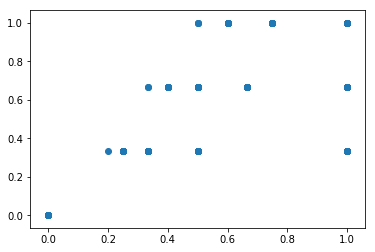

In [53]:
#plot of recalls vs precision
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(recs, precs)
plt.show()

#### This suggests that there are more false negatives than false positives in this prediction
<ul>
<li>Here we had an input dataset of 1278 poster images.</li>
<li>This model was trained on CPU's 4 GB RAM </li>
<li>a simple 1 layer model was used to show that there is a lot of information in posters of each movie that models can extract.</li> 
<li>With a larger dataset, and higher computational powers, the accuracy can be brought higher up.</li>
</ul>
The above reasoning suggests how the image data might outperform models of textual data. Although, in my case, models based on textual data is performing better than model based on image alone.